# [시계열 예측]
---

# 1. 변동의 종류

> 추세변동(trend variation)  
> 순환변동(cyclical variation)  
> 계절변동(seasonal variation  
> 위 변동요인을 동시에 갖는 변동
> 불규칙변동(irregular variation or random variation)

---

# 2. 평활화 기법
## 1 ) SMA(Smoothing Methods Analysis) : 단순이동평균법

> - 단순 이동 평균은 가장 일반적인 평균 유형이다.
> - SMA에서는 최근 데이터 포인트의 합계를 수행하고 기간별로 나눈다.
> - 슬라이딩 너비의 값이 클수록 데이터가 더 평활해지지만, 값이 크면 정확도가 떨어질 수 있다.
> - SMA를 계산하기 위해 pandas의 Series.rolling() 메서드를 사용한다.

### a. Apple 주식을 이용한 단순이동평균(SMA)

In [27]:
# !pip install finance-datareader   # 설치
# !pip install -U finance-datareader # 업데이트


# S&P 500에 등록된 모든 종목 리스트 가져와서 Apple사의 Symbol확인
import FinanceDataReader as fdr
df_spx = fdr.StockListing('S&P500')
# df_spx.head(3)

df_spx.loc[df_spx["Name"] == "Apple Inc.", ["Name", "Symbol"]]
# df_spx.loc[df_spx["Name"] == "Amazon", ["Name", "Symbol"]]  #아마존 symbol

,Name,Symbol
45,Apple Inc.,AAPL


In [31]:
# 애플 가격 데이터 가져오기

df_apple = fdr.DataReader(symbol='AAPL', start='2010') # 애플, 2010년~현재
# df_apple.date_range(start="2020-08", periods=8, freq="W")
## start : 시작일, periods : 생성할 날짜의 개수, freq : 생성할 날짜의 주기
df_apple.head(3)

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2010-01-04,7.64,7.62,7.66,7.58,493730000.0,0.0146
2010-01-05,7.66,7.66,7.70,7.62,601900000.0,0.0026
2010-01-06,7.53,7.66,7.69,7.53,552160000.0,-0.0170


<AxesSubplot:xlabel='Date'>

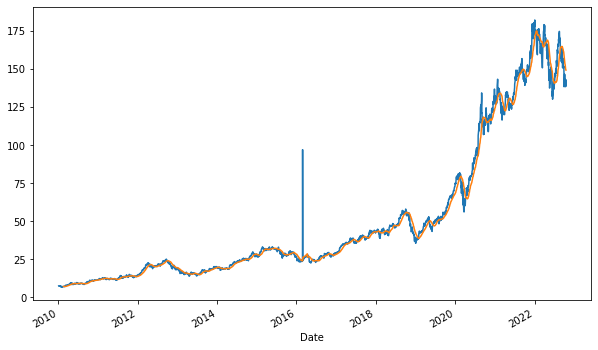

In [47]:
import pandas as pd
df_apple["Close"].plot(figsize=(10,6))  # 파랑
df_apple["Close"].rolling(window=30).mean().shift(1).plot(figsize=(10,6)) # 30일 이동평균(window), 주황
# 1,2,3일 종가로 이동평균(window=3)한 값은 4일 종가와 비교해야하니 shift(1)을 해주어 날짜를 하나 미뤄준다.

## 2 ) EMA(Exponential Moving Aveage) : 지수평활법
> - EMA는새로운 데이터에 더 많은 가중치를 부여하여 최근 데이터에 더욱 초점을맞춘다.
> - EMA의 주요 아이디어는 이전 데이터보다 최근 데이터를 더 선호하는 것이다.
> - 데이터가 오래될수록 데이터에 할당된 가중치가 줄어듭니다. 이 때문에 EMA는 모든 값에 동일한 가중치가 주어지는 SMA에 비해 추세 변화에 더 민감하다.
> - SMA를 계산하기 위해 pandas의 pandas.Series.ewm() 메서드를 사용한다.

### a. 지수평활법(EMA) 지수비교

<AxesSubplot:xlabel='index'>

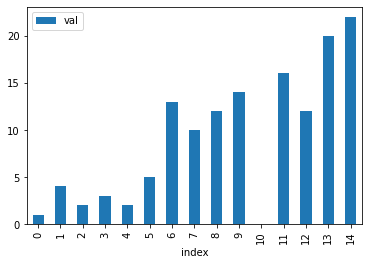

In [43]:
# test data set 만들기
import numpy as np

data = {"val":[1,4,2,3,2,5,13,10,12,14,np.NaN,16,12,20,22]}
df = pd.DataFrame(data).reset_index()
df.plot(kind="bar", x="index", y="val")

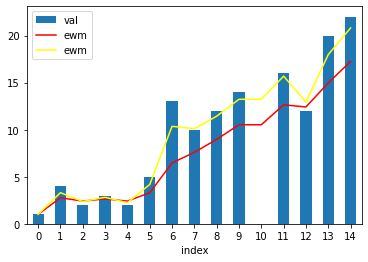

In [49]:
# 지수 0.3, 0.7일 때 지수평활법 비교
import matplotlib.pyplot as plt

df_alpha3 = df.assign(ewm=df["val"].ewm(alpha=0.3).mean()) # 지수 0.3 일 때 data
df_alpha7 = df.assign(ewm=df["val"].ewm(alpha=0.7).mean()) # 지수 0.7 일 때 data

ax = df.plot(kind="bar", x="index", y="val")  # test data
ax2 = df_alpha3.plot(kind="line", x="index", y="ewm", color="red", ax=ax) # test data + 지수 0.3 data(red)
ax3 = df_alpha7.plot(kind="line", x="index", y="ewm", color="yellow", ax=ax2) # 위에꺼 + 지수 0.7 data(yellow)
# plot을 변수에 저장시켜 ax= 에다가 중첩시키면 data 동시 plot 가능
plt.show()

---

# 3. 자기상관함수(ACF), 부분자기상관함수(PACF)

> 자기 상관은 시차(lag)를 적용한 시계열 데이터를 이용하여 계산한다.<br>
> ㄴ 시차를 적용한다는 것은 시차만큼 예측값을 뒤로 이동<br><br>
>
> 주가 시계열 분석을 할 때는 직접 레이블을 만들지 않고 data 자기자신을 레이블 값으로 가짐. 이를 auto regression이라함.<br>
> ㄴ SMA나 EWM을 사용해 예측값을 구하고 이를 shift하여 다음날 데이터의 레이블 값이 되도록한다.<br><br>
>
> ar(auto regression)을 쓰기 위해선 추세가 있으면 안된다. 예측이 어려워짐<br>
> ㄴ so, 추세를 제거해야한다.(순환은 어느정도 괜찮다. 추세, 계절은 x)<br><br>

## 1 ) **ACF**(AutoCorrelation Fincion)
> ACF는 k시간 단위로 구분된 시계열의 관측치 간 상관계수 함수<br>
> 자기상관관계(shift한 값(레이블)과 다음날 값으로)를 구하는 함수<br>
> y(t) ~ y(t−k) 사이의 y들의 자기상관

## 2 ) **PACF**(Partial ACF)
> PACF는 y(t)와 y(t-k)간의 순수한 상관관계<br>
> 관측값과 실제값의 차이(오차)를 가지고 자기상관관계를 구하는 함수<br>
> 그 사이에 존재하는 y(t-1), y(t-2), ,, y(t-k+1)의 영향력은 제거<br>

## 3 ) 정상, 비정상 시계열 확인
> 정상 시계열 : 평균, 분산이 일정할 때. 추세x
- 정상 시계열에서 acf는 상대적으로 빨리 0으로 접근함
- 어느 순간 뚝 떨어질 때 거기만큼 shift한다.

> 비정상 시계열 : 평균 분산이 일정하지 않을 때. 추세o
- 비정상 시계열에서 acf는 천천해 감소하며 종종 큰 양의 값을 가진다.

**따라서, 반대로 acf를 사용해서 data가 정상 시계열인지 아닌지 확인할 수 있다!**
- acf가 뚝 떨어지고, pacf가 천천히 떨어지면. SMA 사용
- acf가 천천히 떨어지고, pacf가 뚝 떨어지면. AR(자기상관) 사용
- 둘 다 떨어지면 ARIMA 사용!

![](https://velog.velcdn.com/images%2Feuisuk-chung%2Fpost%2F40535822-ec23-402f-aa8b-2a4e98dc379d%2Fimage.png)

---
# 4. 정상성, 차분
정상성(stationarity)
> 정상성(stationarity) : 추세나 동향이 없는 상태. 시계열의 평균이 시간 축에 평행.
>
> 시계형 자료가 시계열 모형으로 적합시키기 위한 전체 조건.

차분(differencing)
> 비정상성 시계열은 정상 시계열로 변환해야하며 그 방법으로 차분(differencing)이 있다.
> 
> 차분은 현시점 자료에서 전 시점 자료를 뺴는 것
> 
> 1 ) 일반차분 : 바로 전 시점 자료를 뺴는 것
> 
> 2 ) 계절차분 : 여러 시점 전의 자료를 뺴는 것

---
# 5. 시계열 모형 종류

- (1) AR(p) - 자기 회귀 모형
- (2) MA(q) - 이동평균 모형
- (3) ARMA(p,q)
- (4)ARIMA(p,d,q) - 자기회귀누적이동평균 모형 : 차수의 개수(d)는 거의 2를 넘지 않는다.
  - 여기서 I는 차분을 한다는 의미
- (5)SARIMA(Seasonal ARIMA) - 계절 자기회귀이동평균 모형
  - 여기서 S는 계절성을 의미

## 1 ) AR Models : 자기회기모형
- 종속변수 : 자기자신 / y(t)
- 독립변수 : 이전 시점의 시계열(lag) / y(t), y(t-1), y(t-2) ... y(t-p)
- 파라미터 : 시점 p.

## 2 ) MA Models : 이동평균모형
- 종속변수 : 자기자신 / y(t)
- 독립변수 : 해당시점과 이전 지점들의 errors / [εt,εt−1 ,...,εt−q]
- 파라미터 : 시점 q.

## 3 ) ARMA
- 종속변수 : 자기자신 / y(t)
- 독립변수 : 이전 시점의 시계열 + errors
- 파라미터 : 시점 p, q

## 4 ) ARIMA
- ARMA 모형에 차분(differencing)을 d회 수행해준 모델
- 비정상 모델을 차분하여 정상 데이터로 변형
- 파라미터 : p, q, d


In [ ]:
끝!